In [1]:
# Importing the required libraries
from IPython.display import display
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import time
import easydict
import copy

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm

from time_transformer.transformer import Transformer

# Training device check-up
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

writer = SummaryWriter()

# Defining DOE custom mape formula
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / max(y_true))) * 100

Using device cuda:0


#### FETCHING AND PROCESSING CALENDER FEATURES

In [2]:
# Specifying the path of file
path= r"C:\Users\sashah8\DOE_Graph_Attention_Transformer\DOE MODEL TRAINING\Data Processing\processed_data"
dataset = "L2"

# Listing just the required files
fileList = os.listdir(os.path.join(path, dataset))

# Previewing the required file names
print(fileList)

['COAST.csv', 'EAST.csv', 'FWEST.csv', 'NCENT.csv', 'NORTH.csv', 'SCENT.csv', 'SOUTH.csv', 'WEST.csv']


In [3]:
# Just for previewing the column name
display(pd.read_csv(os.path.join(path, dataset, fileList[0])).head(2))

,ept,mw,tmp
0,2015-01-01 00:00:00,9844.200268,6.8
1,2015-01-01 01:00:00,9653.456269,7.1


In [4]:
# Just for previewing the column name
data = pd.read_csv(os.path.join(path, dataset, fileList[0]), parse_dates=['ept'])
print("Sample dataframe: ")
display(data.head(2))

Sample dataframe: 


,ept,mw,tmp
0,2015-01-01 00:00:00,9844.200268,6.8
1,2015-01-01 01:00:00,9653.456269,7.1


In [5]:
# Fetching the date column only
date_col = data.ept.copy()
date_col.name = "AA_ept"
date_col.head(2)

0   2015-01-01 00:00:00
1   2015-01-01 01:00:00
Name: AA_ept, dtype: datetime64[ns]

In [6]:
# Creating the calendar features
date = pd.DataFrame()
date['Month'] = date_col.dt.month
date['Day'] = date_col.dt.day
date['Hour'] = date_col.dt.hour
date['Weekday'] = date_col.dt.weekday

print("Sample calendar features: ")
display(date.head(2))

print("Available unique categories: ")
display(date.nunique())

print("Total number of observations: ", len(date))

Sample calendar features: 


,Month,Day,Hour,Weekday
0,1,1,0,3
1,1,1,1,3


Available unique categories: 


Month      12
Day        31
Hour       24
Weekday     7
dtype: int64

Total number of observations:  43823


In [7]:
# One-hot encoding the categorical calendar features
date_enc = OneHotEncoder(sparse_output=False)
categorical_data = date_enc.fit_transform(date)
display(categorical_data)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
category_count = [len(x_len) for x_len in date_enc.categories_]
category_count

[12, 31, 24, 7]

#### PROCESSING CONTINUOUS FEATURES FOR ALL AVAILABLE ZONES

PROCESSING LOAD DATA

In [9]:
# Fetching and concatenating the data
load_ds = pd.concat([pd.read_csv(os.path.join(path, dataset, fileName),
                                 usecols= ["mw"]) for fileName in fileList], axis= 1)
load_ds.columns = [i.removesuffix('.csv') for i in fileList]
load_ds = load_ds.add_suffix("_LOAD")
display(load_ds.tail(2))

,COAST_LOAD,EAST_LOAD,FWEST_LOAD,NCENT_LOAD,NORTH_LOAD,SCENT_LOAD,SOUTH_LOAD,WEST_LOAD
43821,10304.624870,1387.051521,3630.184859,12413.090126,804.714775,5769.745220,2829.531899,1238.412254
43822,10019.771129,1357.841863,3628.068853,12084.775970,790.865357,5614.231555,2747.692143,1217.592105


In [10]:
# Creating 1-day lag loads
load_lag_1 = load_ds.shift(24*2).add_suffix("_LAG1")
display(load_lag_1.tail(2))

,COAST_LOAD_LAG1,EAST_LOAD_LAG1,FWEST_LOAD_LAG1,NCENT_LOAD_LAG1,NORTH_LOAD_LAG1,SCENT_LOAD_LAG1,SOUTH_LOAD_LAG1,WEST_LOAD_LAG1
43821,10005.692012,1350.918789,3779.620366,12987.897930,821.959349,5939.445038,2825.076669,1322.793472
43822,9640.110639,1299.794530,3757.453274,12483.833157,801.513104,5699.539181,2699.267507,1301.403501


In [11]:
# Creating 7-day lag loads
load_lag_7 = load_ds.shift(24*7).add_suffix("_LAG7")
display(load_lag_7.tail(2))

,COAST_LOAD_LAG7,EAST_LOAD_LAG7,FWEST_LOAD_LAG7,NCENT_LOAD_LAG7,NORTH_LOAD_LAG7,SCENT_LOAD_LAG7,SOUTH_LOAD_LAG7,WEST_LOAD_LAG7
43821,9876.787820,1216.187797,3619.528769,10749.333909,698.896222,5512.343425,2778.351469,1124.153791
43822,9562.900403,1166.584633,3606.519990,10336.276556,683.081316,5344.858187,2717.746859,1100.076605


In [12]:
# Drop index for equalizing data
drop_idx = load_lag_7.dropna(axis= 0).index[0]
print("Drop data before: ", drop_idx)

Drop data before:  168


PROCESSING TEMPERATURE DATA

In [13]:
# Fetching and concatenating the data
temp_ds = pd.concat([pd.read_csv(os.path.join(path, dataset, fileName),
                                 usecols= ["tmp"]) for fileName in fileList], axis= 1)
temp_ds.columns = [i.removesuffix('.csv') for i in fileList]
temp_ds = temp_ds.add_suffix("_A_TEMP")
display(temp_ds.tail(2))

,COAST_A_TEMP,EAST_A_TEMP,FWEST_A_TEMP,NCENT_A_TEMP,NORTH_A_TEMP,SCENT_A_TEMP,SOUTH_A_TEMP,WEST_A_TEMP
43821,13.7,12.5,13.2,12.5,9.2,12.9,16.6,11.6
43822,12.9,9.1,11.4,9.1,7.0,11.1,15.9,9.6


### PREPARING X AND Y PART

In [14]:
# Concatenating the engineered features
X_continuous = pd.concat([date_col, load_lag_1, load_lag_7, temp_ds], axis=1)
X_continuous = X_continuous.sort_index(axis=1)
X_continuous = X_continuous.iloc[drop_idx:].reset_index(drop=True)

# Fetching the train index from the processed dataframe
train_end_idx = X_continuous[X_continuous.AA_ept.dt.year.between(2015, 2018)].index[-1]
print("The train-test split index is: ", train_end_idx)
print("The last date of train dataset: ")
display(X_continuous.loc[:train_end_idx].tail(2))
print("The first date of test dataset: ")
display(X_continuous.loc[train_end_idx + 1:].head(2))
print('\n')

# Dropping the datetime column after fetching the train-test split index
X_continuous = X_continuous.drop(columns=['AA_ept'])
print("LENGTH OF DATASET: ", len(X_continuous))
display(X_continuous.tail(2))

The train-test split index is:  34895
The last date of train dataset: 


,AA_ept,COAST_A_TEMP,COAST_LOAD_LAG1,COAST_LOAD_LAG7,EAST_A_TEMP,EAST_LOAD_LAG1,EAST_LOAD_LAG7,FWEST_A_TEMP,FWEST_LOAD_LAG1,FWEST_LOAD_LAG7,...,NORTH_LOAD_LAG7,SCENT_A_TEMP,SCENT_LOAD_LAG1,SCENT_LOAD_LAG7,SOUTH_A_TEMP,SOUTH_LOAD_LAG1,SOUTH_LOAD_LAG7,WEST_A_TEMP,WEST_LOAD_LAG1,WEST_LOAD_LAG7
34894,2018-12-31 22:00:00,12.0,10120.036098,9035.216913,11.6,1373.535127,1092.426622,14.3,3257.554084,2861.807930,...,726.724452,13.5,6692.226496,5088.530961,14.8,3351.716113,2535.241223,13.3,1442.003681,1112.468599
34895,2018-12-31 23:00:00,9.9,9759.553782,8674.752421,9.8,1296.361648,993.279927,11.0,3225.068274,2935.515247,...,699.513863,12.7,6439.903363,4797.279932,13.0,3248.779261,2469.963256,8.9,1367.422613,1120.088565


The first date of test dataset: 


,AA_ept,COAST_A_TEMP,COAST_LOAD_LAG1,COAST_LOAD_LAG7,EAST_A_TEMP,EAST_LOAD_LAG1,EAST_LOAD_LAG7,FWEST_A_TEMP,FWEST_LOAD_LAG1,FWEST_LOAD_LAG7,...,NORTH_LOAD_LAG7,SCENT_A_TEMP,SCENT_LOAD_LAG1,SCENT_LOAD_LAG7,SOUTH_A_TEMP,SOUTH_LOAD_LAG1,SOUTH_LOAD_LAG7,WEST_A_TEMP,WEST_LOAD_LAG1,WEST_LOAD_LAG7
34896,2019-01-01 00:00:00,8.0,9505.309786,8417.175110,8.7,1272.748797,988.642094,6.8,3193.257964,2914.990449,...,684.735644,11.6,6274.486949,4590.908104,11.9,3165.677416,2396.517124,5.8,1351.361821,1100.920951
34897,2019-01-01 01:00:00,5.7,9347.130004,8219.786133,8.6,1259.546733,962.315498,5.8,3184.930125,2906.029581,...,679.443659,12.0,6172.533592,4431.257098,10.9,3108.103284,2317.557767,3.7,1336.679123,1085.764682




LENGTH OF DATASET:  43655


,COAST_A_TEMP,COAST_LOAD_LAG1,COAST_LOAD_LAG7,EAST_A_TEMP,EAST_LOAD_LAG1,EAST_LOAD_LAG7,FWEST_A_TEMP,FWEST_LOAD_LAG1,FWEST_LOAD_LAG7,NCENT_A_TEMP,...,NORTH_LOAD_LAG7,SCENT_A_TEMP,SCENT_LOAD_LAG1,SCENT_LOAD_LAG7,SOUTH_A_TEMP,SOUTH_LOAD_LAG1,SOUTH_LOAD_LAG7,WEST_A_TEMP,WEST_LOAD_LAG1,WEST_LOAD_LAG7
43653,13.7,10005.692012,9876.787820,12.5,1350.918789,1216.187797,13.2,3779.620366,3619.528769,12.5,...,698.896222,12.9,5939.445038,5512.343425,16.6,2825.076669,2778.351469,11.6,1322.793472,1124.153791
43654,12.9,9640.110639,9562.900403,9.1,1299.794530,1166.584633,11.4,3757.453274,3606.519990,9.1,...,683.081316,11.1,5699.539181,5344.858187,15.9,2699.267507,2717.746859,9.6,1301.403501,1100.076605


In [15]:
X_categorical = pd.DataFrame(categorical_data)
X_categorical = X_categorical.iloc[drop_idx:].reset_index(drop=True)
print("LENGTH OF DATASET: ", len(X_categorical))
display(X_categorical.tail(2))

LENGTH OF DATASET:  43655


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
43653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [16]:
Y = load_ds.copy()
Y = Y.sort_index(axis=1)
Y = Y.iloc[drop_idx:].reset_index(drop=True)
print("LENGTH OF DATASET: ", len(Y))
display(Y.tail(2))

LENGTH OF DATASET:  43655


,COAST_LOAD,EAST_LOAD,FWEST_LOAD,NCENT_LOAD,NORTH_LOAD,SCENT_LOAD,SOUTH_LOAD,WEST_LOAD
43653,10304.624870,1387.051521,3630.184859,12413.090126,804.714775,5769.745220,2829.531899,1238.412254
43654,10019.771129,1357.841863,3628.068853,12084.775970,790.865357,5614.231555,2747.692143,1217.592105


In [17]:
### SPLITTING THE DATA INTO TRAINING AND TESTING
print("Train samples: ", len(X_continuous.loc[:train_end_idx]))
print("Test samples: ", len(X_continuous.loc[train_end_idx + 1:]))

Train samples:  34896
Test samples:  8759


In [18]:
# Splitting the continuous data into training and test split
X_continuous_train,  X_continuous_test = X_continuous.loc[:train_end_idx], X_continuous.loc[train_end_idx+1:]
print("Train split of continuous data: ")
display(X_continuous_train.tail(2))

# Splitting the categorical data into training and test split
X_categorical_train, X_categorical_test = X_categorical.loc[:train_end_idx], X_categorical.loc[train_end_idx+1:]
print("Train split of categorical data: ")
display(X_categorical_train.tail(2))

# Splitting the target into training and test split
Y_train, Y_test = Y.loc[:train_end_idx],  Y.loc[train_end_idx+1:]
print("Train split of target data Y: ")
display(Y_train.tail(2))

Train split of continuous data: 


,COAST_A_TEMP,COAST_LOAD_LAG1,COAST_LOAD_LAG7,EAST_A_TEMP,EAST_LOAD_LAG1,EAST_LOAD_LAG7,FWEST_A_TEMP,FWEST_LOAD_LAG1,FWEST_LOAD_LAG7,NCENT_A_TEMP,...,NORTH_LOAD_LAG7,SCENT_A_TEMP,SCENT_LOAD_LAG1,SCENT_LOAD_LAG7,SOUTH_A_TEMP,SOUTH_LOAD_LAG1,SOUTH_LOAD_LAG7,WEST_A_TEMP,WEST_LOAD_LAG1,WEST_LOAD_LAG7
34894,12.0,10120.036098,9035.216913,11.6,1373.535127,1092.426622,14.3,3257.554084,2861.807930,11.6,...,726.724452,13.5,6692.226496,5088.530961,14.8,3351.716113,2535.241223,13.3,1442.003681,1112.468599
34895,9.9,9759.553782,8674.752421,9.8,1296.361648,993.279927,11.0,3225.068274,2935.515247,9.8,...,699.513863,12.7,6439.903363,4797.279932,13.0,3248.779261,2469.963256,8.9,1367.422613,1120.088565


Train split of categorical data: 


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
34894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
34895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Train split of target data Y: 


,COAST_LOAD,EAST_LOAD,FWEST_LOAD,NCENT_LOAD,NORTH_LOAD,SCENT_LOAD,SOUTH_LOAD,WEST_LOAD
34894,10008.271141,1271.837587,3120.418939,11775.973366,826.962308,6035.861773,3071.164955,1260.779203
34895,9783.594839,1264.194059,3164.720629,11697.766093,827.759428,5993.974289,3066.891146,1282.542956


In [19]:
print("Shape for continuous variable: ")
print(X_continuous_train.shape, X_continuous_test.shape, "\n")
print("Shape for categorical variable: ")
print(X_categorical_train.shape, X_categorical_test.shape, "\n")
print("Shape for target variable: ")
print(Y_train.shape, Y_test.shape, "\n")
print("Does it cover entire training set: ", (X_continuous_train.shape[0] +
                                              X_continuous_test.shape[0]) == len(X_continuous))

Shape for continuous variable: 
(34896, 24) (8759, 24) 

Shape for categorical variable: 
(34896, 74) (8759, 74) 

Shape for target variable: 
(34896, 8) (8759, 8) 

Does it cover entire training set:  True


### SCALING THE DATA

In [20]:
# Scaling values using min-max scaler
mm_scaler_X = MinMaxScaler()
mm_scaler_Y = MinMaxScaler()

In [21]:
# Scaling continuous X train part
X_scaled_continuous_train = mm_scaler_X.fit_transform(X_continuous_train)

# Using the fit_scaler to scale the X test part
X_scaled_continuous_test = mm_scaler_X.transform(X_continuous_test)

print("Scaled continuous X train: ")
display(X_scaled_continuous_train)

Scaled continuous X train: 


array([[0.47239264, 0.23449139, 0.19856039, ..., 0.20869565, 0.30745511,
        0.54746011],
       [0.47443763, 0.22237185, 0.18389753, ..., 0.20173913, 0.30554355,
        0.52531792],
       [0.43353783, 0.21880106, 0.17227783, ..., 0.19478261, 0.3114404 ,
        0.51768315],
       ...,
       [0.5194274 , 0.25188487, 0.16303425, ..., 0.54434783, 0.57091494,
        0.2977502 ],
       [0.49079755, 0.21976441, 0.13637228, ..., 0.51130435, 0.52618253,
        0.28281367],
       [0.44785276, 0.19205345, 0.10866269, ..., 0.43478261, 0.47110278,
        0.28844118]])

In [22]:
# Scaling target Y train part
Y_scaled_train = mm_scaler_Y.fit_transform(Y_train)

# Using the fit_scaler to scale the Y test part
Y_scaled_test = mm_scaler_Y.transform(Y_test)

print("Scaled continuous Y train: ")
display(Y_scaled_train)

Scaled continuous Y train: 


array([[0.26216915, 0.55021825, 0.2091388 , ..., 0.38905282, 0.3581734 ,
        0.55546358],
       [0.26325241, 0.55072333, 0.20228984, ..., 0.39087589, 0.3602255 ,
        0.5552914 ],
       [0.27329606, 0.56994517, 0.20106199, ..., 0.3965838 , 0.37146996,
        0.56740107],
       ...,
       [0.22435239, 0.27169718, 0.72673052, ..., 0.23657667, 0.28044529,
        0.38772706],
       [0.21117283, 0.26442939, 0.73149934, ..., 0.22784033, 0.27551215,
        0.39234429],
       [0.19390153, 0.2602616 , 0.75374987, ..., 0.22386241, 0.27451492,
        0.4084173 ]])

In [23]:
# Converting a multivariate dataset into slices of samples
def split_data(calendar_data, x_data, y_data, n_steps, n_overlap):
    calendar, x, y = list(), list(), list()
    for i in range(0, len(x_data), n_steps-n_overlap):

        # Finding the split index
        end_idx = i + n_steps

        # Break the loop at end of dataset
        if end_idx > len(x_data):
            break

        # Appending the custom created samples with desired time-steps and features
        sample_calendar, sample_x, sample_y = calendar_data[i:end_idx, :], \
                                              x_data[i:end_idx, :], \
                                              y_data[i:end_idx, :]
        calendar.append(sample_calendar)
        x.append(sample_x)
        y.append(sample_y)

    return np.array(calendar), np.array(x), np.array(y)

In [24]:
num_steps = 24
train_num_overlap = 23
test_num_overlap = 0

processed_data_train = split_data(calendar_data=X_categorical_train.to_numpy(),
                            x_data=X_scaled_continuous_train,
                            y_data=Y_scaled_train,
                            n_steps=num_steps, n_overlap=train_num_overlap)

processed_data_test = split_data(calendar_data=X_categorical_test.to_numpy(),
                            x_data=X_scaled_continuous_test,
                            y_data=Y_scaled_test,
                            n_steps=num_steps, n_overlap=test_num_overlap)

print("Shape of the created samples for training: ", processed_data_train[2].shape)
print("Shape of the created samples for testing: ", processed_data_test[2].shape)

Shape of the created samples for training:  (34873, 24, 8)
Shape of the created samples for testing:  (364, 24, 8)


In [25]:
## Sample check for sanity
print("First sample: \n")
display(processed_data_train[1][0])

First sample: 



array([[0.47239264, 0.23449139, 0.19856039, 0.2891791 , 0.42362843,
        0.30747691, 0.15572233, 0.01102423, 0.29986234, 0.2891791 ,
        0.30745137, 0.33139125, 0.23214286, 0.33630549, 0.3751176 ,
        0.24105461, 0.26618244, 0.29388401, 0.39732143, 0.35618171,
        0.40075164, 0.20869565, 0.30745511, 0.54746011],
       [0.47443763, 0.22237185, 0.18389753, 0.2630597 , 0.416606  ,
        0.29801661, 0.15384615, 0.00917475, 0.29095308, 0.2630597 ,
        0.29585628, 0.32021747, 0.22727273, 0.33487899, 0.36340769,
        0.22033898, 0.25561296, 0.28169351, 0.34598214, 0.33567322,
        0.40115179, 0.20173913, 0.30554355, 0.52531792],
       [0.43353783, 0.21880106, 0.17227783, 0.2369403 , 0.42127419,
        0.29282212, 0.14821764, 0.01229659, 0.28252911, 0.2369403 ,
        0.29445531, 0.31298758, 0.22402597, 0.33975427, 0.35411245,
        0.20150659, 0.25812192, 0.27483003, 0.31026786, 0.33129919,
        0.39264419, 0.19478261, 0.3114404 , 0.51768315],
       [0.406

In [26]:
print("Second sample: \n")
display(processed_data_train[1][1])

Second sample: 



array([[0.47443763, 0.22237185, 0.18389753, 0.2630597 , 0.416606  ,
        0.29801661, 0.15384615, 0.00917475, 0.29095308, 0.2630597 ,
        0.29585628, 0.32021747, 0.22727273, 0.33487899, 0.36340769,
        0.22033898, 0.25561296, 0.28169351, 0.34598214, 0.33567322,
        0.40115179, 0.20173913, 0.30554355, 0.52531792],
       [0.43353783, 0.21880106, 0.17227783, 0.2369403 , 0.42127419,
        0.29282212, 0.14821764, 0.01229659, 0.28252911, 0.2369403 ,
        0.29445531, 0.31298758, 0.22402597, 0.33975427, 0.35411245,
        0.20150659, 0.25812192, 0.27483003, 0.31026786, 0.33129919,
        0.39264419, 0.19478261, 0.3114404 , 0.51768315],
       [0.40695297, 0.22580892, 0.17013913, 0.20895522, 0.42336256,
        0.29393606, 0.13883677, 0.01355201, 0.27738416, 0.20895522,
        0.30480828, 0.31427817, 0.2224026 , 0.35291159, 0.35720014,
        0.18455744, 0.26746582, 0.27223788, 0.29910714, 0.33517498,
        0.38453863, 0.18086957, 0.32073627, 0.5127434 ],
       [0.388

In [27]:
# Dividing the sampled data - training
categorical_samples_training = torch.Tensor(processed_data_train[0])
continuous_samples_training = torch.Tensor(processed_data_train[1])
target_samples_training = torch.Tensor(processed_data_train[2])

# Dividing the sampled data - testing
categorical_samples_testing = torch.Tensor(processed_data_test[0])
continuous_samples_testing = torch.Tensor(processed_data_test[1])
target_samples_testing = torch.Tensor(processed_data_test[2])

In [28]:
print("Shape of categorical samples - training: ", categorical_samples_training.shape)
print("Shape of continuous samples - training: ", continuous_samples_training.shape)
print("Shape of target samples - training: ", target_samples_training.shape)
print("\n")
print("Shape of categorical samples - testing: ", categorical_samples_testing.shape)
print("Shape of continuous samples - testing: ", continuous_samples_testing.shape)
print("Shape of target samples - testing: ", target_samples_testing.shape)

Shape of categorical samples - training:  torch.Size([34873, 24, 74])
Shape of continuous samples - training:  torch.Size([34873, 24, 24])
Shape of target samples - training:  torch.Size([34873, 24, 8])


Shape of categorical samples - testing:  torch.Size([364, 24, 74])
Shape of continuous samples - testing:  torch.Size([364, 24, 24])
Shape of target samples - testing:  torch.Size([364, 24, 8])


### CREATING DATALOADER

In [29]:
BATCH_SIZE = 128

In [30]:
class TimeSeriesLoader(Dataset):
    def __init__(self, categorical, continuous, target):
        self.categorical, self.continuous, self.target = categorical, continuous, target

    def __len__(self):
        return len(self.categorical)

    def __getitem__(self, idx):
        return self.categorical[idx], self.continuous[idx], self.target[idx]

In [31]:
train_dataset = TimeSeriesLoader(categorical_samples_training,
                                 continuous_samples_training,
                                 target_samples_training)

test_dataset = TimeSeriesLoader(categorical_samples_testing,
                                continuous_samples_testing,
                                target_samples_testing)

In [32]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [33]:
print("Number of batches in train dataloader: ", len(train_dataloader))
print("Number of batches in test dataloader: ", len(test_dataloader))

Number of batches in train dataloader:  273
Number of batches in test dataloader:  3


In [34]:
categorical_var_shape = train_dataloader.dataset.categorical.shape
continuous_var_shape = train_dataloader.dataset.continuous.shape
target_var_shape = train_dataloader.dataset.target.shape

print("Shape of categorical variables: ", categorical_var_shape)
print("Shape of continuous variables: ", continuous_var_shape)
print("Shape of target variables: ", target_var_shape)

Shape of categorical variables:  torch.Size([34873, 24, 74])
Shape of continuous variables:  torch.Size([34873, 24, 24])
Shape of target variables:  torch.Size([34873, 24, 8])


In [35]:
# Specifying number of zones and features per zone
num_zones = target_var_shape[2]
num_zone_features = int(continuous_var_shape[2] / target_var_shape[2])
print("Number of zones: ", num_zones)
print("Number of features per zone: ", num_zone_features)

Number of zones:  8
Number of features per zone:  3


### DEFINING LOSS FUNCTION

In [36]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles

    def forward(self, pred, target):
        assert not target.requires_grad
        assert pred.size(0) == target.size(0)
        assert pred.size(1) == target.size(1)
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target.reshape(-1,1) - pred[:, :, i].reshape(-1,1)
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss

In [37]:
torch.manual_seed(111)

quantile_list = np.arange(1, 10) * 0.1

pinball_loss_func = QuantileLoss(quantile_list)

### DEFINING MODEL ARCHITECTURE

In [38]:
config_args = easydict.EasyDict(
        {
            "device": torch.device("cuda")
            if torch.cuda.is_available()
            else torch.device("cpu"),
            "learning_rate": 2e-4,
            "max_iter": 1000,
            "epochs": 25
        }
    )

model_args = easydict.EasyDict(
        {
            "d_input": 6 + X_categorical_train.shape[1],     # Model input -> Continuous + Categorical
            "d_output": 9,                                   # Model output -> Quantile predictions
            "d_model": 16,                                   # Model latent dimension
            "q": 3,                                          # Query and Key dimensions
            "v": 3,                                          # Value dimensions
            "h": 3,                                          # Number of heads
            "N": 1,                                          # Number of stacked of encoder and decoder
            "attention_size": 24,                            # Attention window
            "dropout": 0.9,                                  # Dropout rate
            "pe": "regular",                                 # Positional encoding used
            "chunk_mode": None,                              # Default -> MultiHeadAttention
        }
    )

# Making directories to store values
if not os.path.exists("logs"):
    os.mkdir("logs")
if not os.path.exists("models"):
    os.mkdir("models")

### INSTANTIATING MODELS -> VAE AND LSTM

In [39]:
# Address for saved VAE models
vae_dirname = os.path.join(os.path.dirname(os.getcwd()), "VAE_LSTM", "vae_models")

# Loading the vae models
vae_model_1 = torch.load(os.path.join(vae_dirname, "L2_best_zone_1.pth"))
vae_model_2 = torch.load(os.path.join(vae_dirname, "L2_best_zone_2.pth"))
vae_model_3 = torch.load(os.path.join(vae_dirname, "L2_best_zone_3.pth"))
vae_model_4 = torch.load(os.path.join(vae_dirname, "L2_best_zone_4.pth"))
vae_model_5 = torch.load(os.path.join(vae_dirname, "L2_best_zone_5.pth"))
vae_model_6 = torch.load(os.path.join(vae_dirname, "L2_best_zone_6.pth"))
vae_model_7 = torch.load(os.path.join(vae_dirname, "L2_best_zone_7.pth"))
vae_model_8 = torch.load(os.path.join(vae_dirname, "L2_best_zone_8.pth"))

vae_models = nn.ModuleList([vae_model_1, vae_model_2, vae_model_3, vae_model_4,
                            vae_model_5, vae_model_6, vae_model_7, vae_model_8])
print("Number of vae models: ", len(vae_models))

Number of vae models:  8


In [40]:
# Instantiating transformer corresponding to each zone
transformer_model = Transformer(model_args.d_input, model_args.d_model, model_args.d_output,
                                model_args.q, model_args.v, model_args.h, model_args.N,
                                attention_size=model_args.attention_size, dropout=model_args.dropout,
                                chunk_mode=model_args.chunk_mode, pe=model_args.pe).to(device)

transformer_models = nn.ModuleList([transformer_model for _ in range(num_zones)])
print("Number of transformer models: ", len(transformer_models))

Number of transformer models:  8


In [41]:
class VAE_TRANSFORMER(nn.Module):
    def __init__(self, zonal_vae, zonal_transformer):
        super(VAE_TRANSFORMER, self).__init__()
        self.zonal_vae = zonal_vae
        self.zonal_transformer = zonal_transformer

    def forward(self, categorical, zonal_continuous):
        out_var = self.zonal_vae(zonal_continuous)
        in_transformer = torch.cat((categorical, zonal_continuous, out_var[1]), axis=-1)
        out_transformer = self.zonal_transformer(in_transformer)
        return out_var, out_transformer

In [42]:
def pinball(yhat, tau, y):
    if yhat >= y:
        score = (1 - tau) * (yhat - y)
    else:
        score = tau * (y - yhat)
    return score

In [43]:
def frozen_param_model(net):
    for name, param in net.named_parameters():
        if param.requires_grad and 'zonal_vae' in name:
            param.requires_grad = False

    non_frozen_param = [p for p in net.parameters() if p.requires_grad]
    return non_frozen_param

In [44]:
def save_checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def load_from_checkpoint(model, filename):
    model.load_state_dict(torch.load(filename))
    return model

def init_weights(model):
    if isinstance(model, nn.Linear):
        torch.nn.init.kaiming_uniform_(model.weight, nonlinearity='relu')
        model.bias.data.fill_(0.01)

### DEFINING ZONAL MODEL

In [45]:
model_1 = VAE_TRANSFORMER(vae_models[0], transformer_models[0]).apply(init_weights)
model_2 = VAE_TRANSFORMER(vae_models[1], transformer_models[1]).apply(init_weights)
model_3 = VAE_TRANSFORMER(vae_models[2], transformer_models[2]).apply(init_weights)
model_4 = VAE_TRANSFORMER(vae_models[3], transformer_models[3]).apply(init_weights)
model_5 = VAE_TRANSFORMER(vae_models[4], transformer_models[4]).apply(init_weights)
model_6 = VAE_TRANSFORMER(vae_models[5], transformer_models[5]).apply(init_weights)
model_7 = VAE_TRANSFORMER(vae_models[6], transformer_models[6]).apply(init_weights)
model_8 = VAE_TRANSFORMER(vae_models[7], transformer_models[7]).apply(init_weights)

In [46]:
# Defining optimizer with frozen vae parameters -> Just training the Transformer
optimizer_1 = optim.Adam(frozen_param_model(model_1), lr=config_args.learning_rate)
optimizer_2 = optim.Adam(frozen_param_model(model_2), lr=config_args.learning_rate)
optimizer_3 = optim.Adam(frozen_param_model(model_3), lr=config_args.learning_rate)
optimizer_4 = optim.Adam(frozen_param_model(model_4), lr=config_args.learning_rate)
optimizer_5 = optim.Adam(frozen_param_model(model_5), lr=config_args.learning_rate)
optimizer_6 = optim.Adam(frozen_param_model(model_6), lr=config_args.learning_rate)
optimizer_7 = optim.Adam(frozen_param_model(model_7), lr=config_args.learning_rate)
optimizer_8 = optim.Adam(frozen_param_model(model_8), lr=config_args.learning_rate)

### PERFORMING MODEL TRAINING

[Epoch  25/25]: 100%|██████████| 34873/34873 [01:34<00:00, 367.99it/s, loss_1=0.153, loss_2=0.143, loss_3=0.126, loss_4=0.139, loss_5=0.148, loss_6=0.118, loss_7=0.146, loss_8=0.132]                     


All model stopped training at the end of epoch and final checkpoint saved !


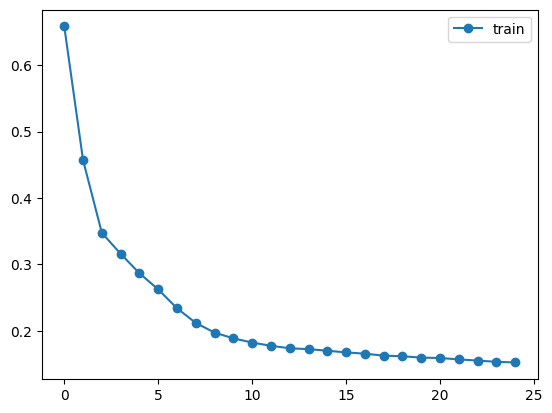

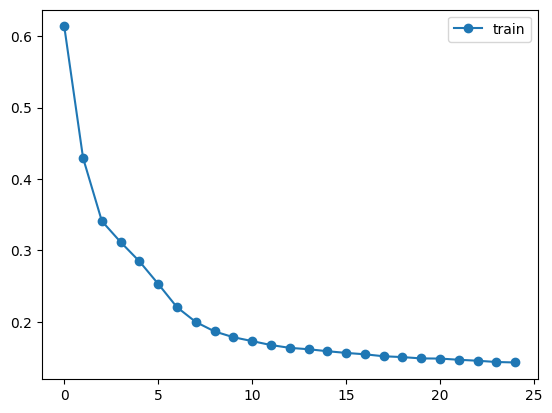

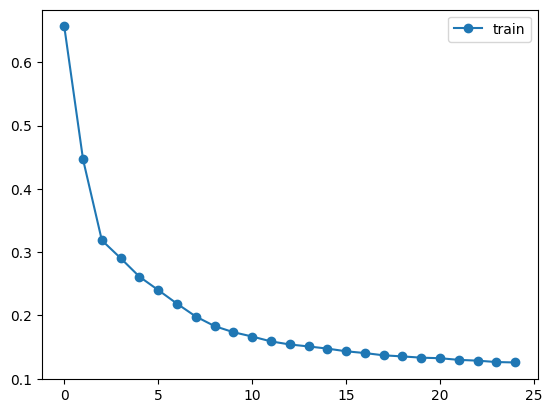

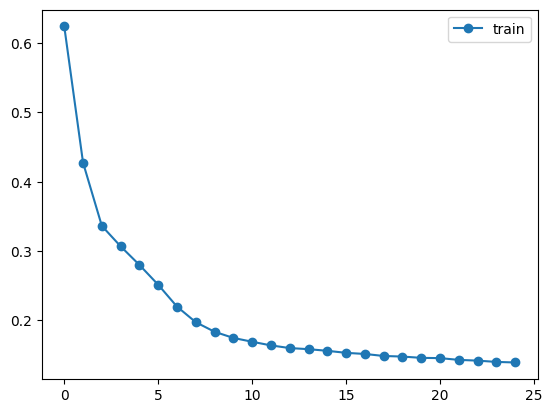

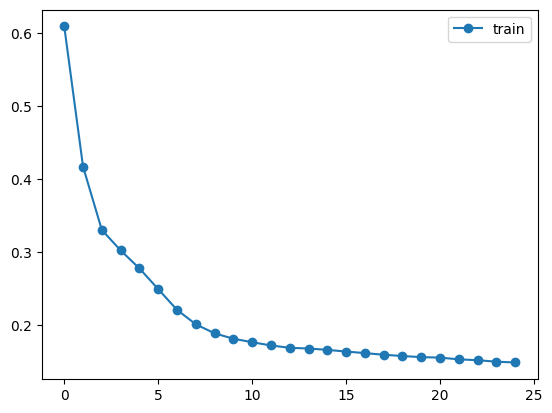

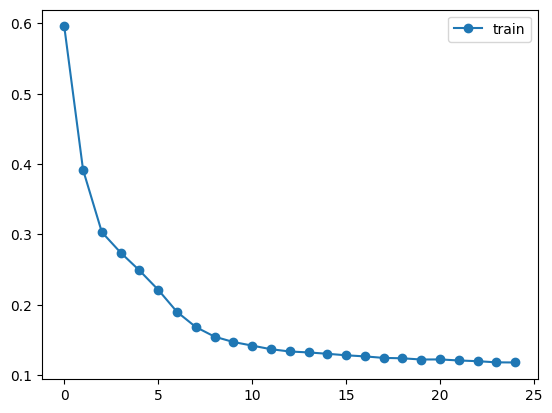

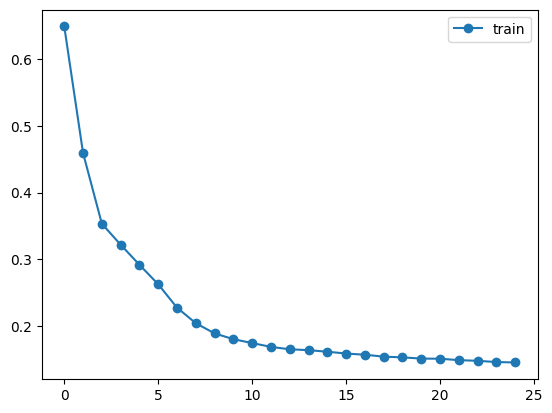

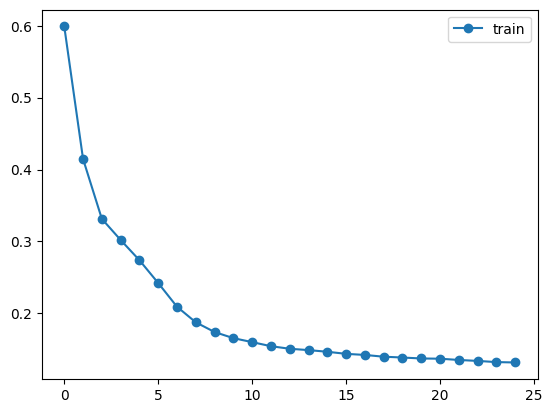


Total time of training: 0.6984623914294773 hours


In [47]:
start_time = time.time()

hist_loss_1 = np.zeros(config_args.epochs)
hist_loss_2 = np.zeros(config_args.epochs)
hist_loss_3 = np.zeros(config_args.epochs)
hist_loss_4 = np.zeros(config_args.epochs)
hist_loss_5 = np.zeros(config_args.epochs)
hist_loss_6 = np.zeros(config_args.epochs)
hist_loss_7 = np.zeros(config_args.epochs)
hist_loss_8 = np.zeros(config_args.epochs)

for epoch in range(config_args.epochs):

    # Switching all models in training mode
    model_1.train()
    model_2.train()
    model_3.train()
    model_4.train()
    model_5.train()
    model_6.train()
    model_7.train()
    model_8.train()

    running_loss_1 = 0
    running_loss_2 = 0
    running_loss_3 = 0
    running_loss_4 = 0
    running_loss_5 = 0
    running_loss_6 = 0
    running_loss_7 = 0
    running_loss_8 = 0

    with tqdm(total=len(train_dataloader.dataset),
              desc=f"[Epoch {epoch+1:3d}/{config_args.epochs}]") as pbar:

        for batch, (categorical_var, continuous_var, target_var) in enumerate(train_dataloader):

            # Setting the gradients to zero
            optimizer_1.zero_grad()
            optimizer_2.zero_grad()
            optimizer_3.zero_grad()
            optimizer_4.zero_grad()
            optimizer_5.zero_grad()
            optimizer_6.zero_grad()
            optimizer_7.zero_grad()
            optimizer_8.zero_grad()

            # The categorical variables are common for all zones.
            common_categorical = copy.deepcopy(categorical_var).to(device)

            zone_1_continuous = copy.deepcopy(continuous_var[:, :, 0:3]).to(device)
            zone_2_continuous = copy.deepcopy(continuous_var[:, :, 3:6]).to(device)
            zone_3_continuous = copy.deepcopy(continuous_var[:, :, 6:9]).to(device)
            zone_4_continuous = copy.deepcopy(continuous_var[:, :, 9:12]).to(device)
            zone_5_continuous = copy.deepcopy(continuous_var[:, :, 12:15]).to(device)
            zone_6_continuous = copy.deepcopy(continuous_var[:, :, 15:18]).to(device)
            zone_7_continuous = copy.deepcopy(continuous_var[:, :, 18:21]).to(device)
            zone_8_continuous = copy.deepcopy(continuous_var[:, :, 21:24]).to(device)

            zone_1_target = copy.deepcopy(target_var[:, :, 0:1])
            zone_2_target = copy.deepcopy(target_var[:, :, 1:2])
            zone_3_target = copy.deepcopy(target_var[:, :, 2:3])
            zone_4_target = copy.deepcopy(target_var[:, :, 3:4])
            zone_5_target = copy.deepcopy(target_var[:, :, 4:5])
            zone_6_target = copy.deepcopy(target_var[:, :, 5:6])
            zone_7_target = copy.deepcopy(target_var[:, :, 6:7])
            zone_8_target = copy.deepcopy(target_var[:, :, 7:8])

            # Propagating through the network
            out_vae_1, out_transformer_1 = model_1(common_categorical, zone_1_continuous)
            out_vae_2, out_transformer_2 = model_2(common_categorical, zone_2_continuous)
            out_vae_3, out_transformer_3 = model_3(common_categorical, zone_3_continuous)
            out_vae_4, out_transformer_4 = model_4(common_categorical, zone_4_continuous)
            out_vae_5, out_transformer_5 = model_5(common_categorical, zone_5_continuous)
            out_vae_6, out_transformer_6 = model_6(common_categorical, zone_6_continuous)
            out_vae_7, out_transformer_7 = model_7(common_categorical, zone_7_continuous)
            out_vae_8, out_transformer_8 = model_8(common_categorical, zone_8_continuous)

            # Calculating the pinball loss
            loss_1 = pinball_loss_func(out_transformer_1, zone_1_target.to(device))
            loss_2 = pinball_loss_func(out_transformer_2, zone_2_target.to(device))
            loss_3 = pinball_loss_func(out_transformer_3, zone_3_target.to(device))
            loss_4 = pinball_loss_func(out_transformer_4, zone_4_target.to(device))
            loss_5 = pinball_loss_func(out_transformer_5, zone_5_target.to(device))
            loss_6 = pinball_loss_func(out_transformer_6, zone_6_target.to(device))
            loss_7 = pinball_loss_func(out_transformer_7, zone_7_target.to(device))
            loss_8 = pinball_loss_func(out_transformer_8, zone_8_target.to(device))

            # Back-Propagating the loss
            loss_1.backward()
            loss_2.backward()
            loss_3.backward()
            loss_4.backward()
            loss_5.backward()
            loss_6.backward()
            loss_7.backward()
            loss_8.backward()

            # Updating the parameters
            optimizer_1.step()
            optimizer_2.step()
            optimizer_3.step()
            optimizer_4.step()
            optimizer_5.step()
            optimizer_6.step()
            optimizer_7.step()
            optimizer_8.step()

            # Accumulating the running loss
            running_loss_1 += loss_1.item()
            running_loss_2 += loss_2.item()
            running_loss_3 += loss_3.item()
            running_loss_4 += loss_4.item()
            running_loss_5 += loss_5.item()
            running_loss_6 += loss_6.item()
            running_loss_7 += loss_7.item()
            running_loss_8 += loss_8.item()

            pbar.set_postfix({
                'loss_1': running_loss_1/(batch+1),
                'loss_2': running_loss_2/(batch+1),
                'loss_3': running_loss_3/(batch+1),
                'loss_4': running_loss_4/(batch+1),
                'loss_5': running_loss_5/(batch+1),
                'loss_6': running_loss_6/(batch+1),
                'loss_7': running_loss_7/(batch+1),
                'loss_8': running_loss_8/(batch+1)
                              })
            pbar.update(zone_1_continuous.shape[0])

            train_loss_1 = running_loss_1/len(train_dataloader)
            train_loss_2 = running_loss_2/len(train_dataloader)
            train_loss_3 = running_loss_3/len(train_dataloader)
            train_loss_4 = running_loss_4/len(train_dataloader)
            train_loss_5 = running_loss_5/len(train_dataloader)
            train_loss_6 = running_loss_6/len(train_dataloader)
            train_loss_7 = running_loss_7/len(train_dataloader)
            train_loss_8 = running_loss_8/len(train_dataloader)

            pbar.set_postfix({
                'loss_1': train_loss_1,
                'loss_2': train_loss_2,
                'loss_3': train_loss_3,
                'loss_4': train_loss_4,
                'loss_5': train_loss_5,
                'loss_6': train_loss_6,
                'loss_7': train_loss_7,
                'loss_8': train_loss_8,
                              })

            hist_loss_1[epoch] = train_loss_1
            hist_loss_2[epoch] = train_loss_2
            hist_loss_3[epoch] = train_loss_3
            hist_loss_4[epoch] = train_loss_4
            hist_loss_5[epoch] = train_loss_5
            hist_loss_6[epoch] = train_loss_6
            hist_loss_7[epoch] = train_loss_7
            hist_loss_8[epoch] = train_loss_8


print("All model stopped training at the end of epoch and final checkpoint saved !")
save_checkpoint(model_1, os.path.join(os.getcwd(), "vae_transformer_checkpoint",
                                                      "vae_transformer_best_1.pth"))
save_checkpoint(model_2, os.path.join(os.getcwd(), "vae_transformer_checkpoint",
                                                      "vae_transformer_best_2.pth"))
save_checkpoint(model_3, os.path.join(os.getcwd(), "vae_transformer_checkpoint",
                                                      "vae_transformer_best_3.pth"))
save_checkpoint(model_4, os.path.join(os.getcwd(), "vae_transformer_checkpoint",
                                                      "vae_transformer_best_4.pth"))
save_checkpoint(model_5, os.path.join(os.getcwd(), "vae_transformer_checkpoint",
                                                      "vae_transformer_best_5.pth"))
save_checkpoint(model_6, os.path.join(os.getcwd(), "vae_transformer_checkpoint",
                                                      "vae_transformer_best_6.pth"))
save_checkpoint(model_7, os.path.join(os.getcwd(), "vae_transformer_checkpoint",
                                                      "vae_transformer_best_7.pth"))
save_checkpoint(model_8, os.path.join(os.getcwd(), "vae_transformer_checkpoint",
                                                      "vae_transformer_best_8.pth"))


plt.plot(np.trim_zeros(hist_loss_1, 'b'), 'o-', label='train')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_2, 'b'), 'o-', label='train')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_3, 'b'), 'o-', label='train')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_4, 'b'), 'o-', label='train')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_5, 'b'), 'o-', label='train')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_6, 'b'), 'o-', label='train')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_7, 'b'), 'o-', label='train')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_8, 'b'), 'o-', label='train')
plt.legend()
plt.show()

end_time = time.time()

total_time = end_time - start_time
print("\nTotal time of training: {} hours".format(total_time/3600))

### LOADING AND GENERATING RESULTS ON TEST DATALOADER

In [48]:
# Loading the models
best_vae_transformer_1 = load_from_checkpoint(model_1, os.path.join(os.getcwd(),
                                                                    "vae_transformer_checkpoint",
                                                                    "vae_transformer_best_1.pth"))
best_vae_transformer_2 = load_from_checkpoint(model_2, os.path.join(os.getcwd(),
                                                                    "vae_transformer_checkpoint",
                                                                    "vae_transformer_best_2.pth"))
best_vae_transformer_3 = load_from_checkpoint(model_3, os.path.join(os.getcwd(),
                                                                    "vae_transformer_checkpoint",
                                                                    "vae_transformer_best_3.pth"))
best_vae_transformer_4 = load_from_checkpoint(model_4, os.path.join(os.getcwd(),
                                                                    "vae_transformer_checkpoint",
                                                                    "vae_transformer_best_4.pth"))
best_vae_transformer_5 = load_from_checkpoint(model_5, os.path.join(os.getcwd(),
                                                                    "vae_transformer_checkpoint",
                                                                    "vae_transformer_best_5.pth"))
best_vae_transformer_6 = load_from_checkpoint(model_6, os.path.join(os.getcwd(),
                                                                    "vae_transformer_checkpoint",
                                                                    "vae_transformer_best_6.pth"))
best_vae_transformer_7 = load_from_checkpoint(model_7, os.path.join(os.getcwd(),
                                                                    "vae_transformer_checkpoint",
                                                                    "vae_transformer_best_7.pth"))
best_vae_transformer_8 = load_from_checkpoint(model_8, os.path.join(os.getcwd(),
                                                                    "vae_transformer_checkpoint",
                                                                    "vae_transformer_best_8.pth"))

In [49]:
quantile_pred_1 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
quantile_pred_2 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
quantile_pred_3 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
quantile_pred_4 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
quantile_pred_5 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
quantile_pred_6 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
quantile_pred_7 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
quantile_pred_8 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
idx_pred_1 = 0
idx_pred_2 = 0
idx_pred_3 = 0
idx_pred_4 = 0
idx_pred_5 = 0
idx_pred_6 = 0
idx_pred_7 = 0
idx_pred_8 = 0

# Switching all models to eval mode
model_1.eval()
model_2.eval()
model_3.eval()
model_4.eval()
model_5.eval()
model_6.eval()
model_7.eval()
model_8.eval()

with torch.no_grad():
    for (categorical_var, continuous_var, target_var) in tqdm(test_dataloader, total=len(test_dataloader)):

        # The categorical variables are common for all zones.
        common_categorical = copy.deepcopy(categorical_var).to(device)

        zone_1_continuous = copy.deepcopy(continuous_var[:, :, 0:3]).to(device)
        zone_2_continuous = copy.deepcopy(continuous_var[:, :, 3:6]).to(device)
        zone_3_continuous = copy.deepcopy(continuous_var[:, :, 6:9]).to(device)
        zone_4_continuous = copy.deepcopy(continuous_var[:, :, 9:12]).to(device)
        zone_5_continuous = copy.deepcopy(continuous_var[:, :, 12:15]).to(device)
        zone_6_continuous = copy.deepcopy(continuous_var[:, :, 15:18]).to(device)
        zone_7_continuous = copy.deepcopy(continuous_var[:, :, 18:21]).to(device)
        zone_8_continuous = copy.deepcopy(continuous_var[:, :, 21:24]).to(device)

        zone_1_target = copy.deepcopy(target_var[:, :, 0:1])
        zone_2_target = copy.deepcopy(target_var[:, :, 1:2])
        zone_3_target = copy.deepcopy(target_var[:, :, 2:3])
        zone_4_target = copy.deepcopy(target_var[:, :, 3:4])
        zone_5_target = copy.deepcopy(target_var[:, :, 4:5])
        zone_6_target = copy.deepcopy(target_var[:, :, 5:6])
        zone_7_target = copy.deepcopy(target_var[:, :, 6:7])
        zone_8_target = copy.deepcopy(target_var[:, :, 7:8])

        # Propagating through the network
        out_vae_1, out_transformer_1 = model_1(common_categorical, zone_1_continuous)
        out_vae_2, out_transformer_2 = model_2(common_categorical, zone_2_continuous)
        out_vae_3, out_transformer_3 = model_3(common_categorical, zone_3_continuous)
        out_vae_4, out_transformer_4 = model_4(common_categorical, zone_4_continuous)
        out_vae_5, out_transformer_5 = model_5(common_categorical, zone_5_continuous)
        out_vae_6, out_transformer_6 = model_6(common_categorical, zone_6_continuous)
        out_vae_7, out_transformer_7 = model_7(common_categorical, zone_7_continuous)
        out_vae_8, out_transformer_8 = model_8(common_categorical, zone_8_continuous)

        # Concatenating the predictions
        quantile_pred_1[idx_pred_1:idx_pred_1+zone_1_continuous.shape[0]] = out_transformer_1.cpu().numpy()

        quantile_pred_2[idx_pred_2:idx_pred_2+zone_2_continuous.shape[0]] = out_transformer_2.cpu().numpy()

        quantile_pred_3[idx_pred_3:idx_pred_3+zone_3_continuous.shape[0]] = out_transformer_3.cpu().numpy()

        quantile_pred_4[idx_pred_4:idx_pred_4+zone_4_continuous.shape[0]] = out_transformer_4.cpu().numpy()

        quantile_pred_5[idx_pred_5:idx_pred_5+zone_5_continuous.shape[0]] = out_transformer_5.cpu().numpy()

        quantile_pred_6[idx_pred_6:idx_pred_6+zone_6_continuous.shape[0]] = out_transformer_6.cpu().numpy()

        quantile_pred_7[idx_pred_7:idx_pred_7+zone_7_continuous.shape[0]] = out_transformer_7.cpu().numpy()

        quantile_pred_8[idx_pred_8:idx_pred_8+zone_8_continuous.shape[0]] = out_transformer_8.cpu().numpy()

        idx_pred_1 += zone_1_continuous.shape[0]
        idx_pred_2 += zone_2_continuous.shape[0]
        idx_pred_3 += zone_3_continuous.shape[0]
        idx_pred_4 += zone_4_continuous.shape[0]
        idx_pred_5 += zone_5_continuous.shape[0]
        idx_pred_6 += zone_6_continuous.shape[0]
        idx_pred_7 += zone_7_continuous.shape[0]
        idx_pred_8 += zone_8_continuous.shape[0]

100%|██████████| 3/3 [00:00<00:00,  4.09it/s]


#### FORMATTING PREDICTED AND TRUE DATA FOR GENERATING RESULTS

In [50]:
# Reshaping the predicted quantiles
quantile_pred_arr_1 = quantile_pred_1.reshape(-1, model_args.d_output)
quantile_pred_arr_2 = quantile_pred_2.reshape(-1, model_args.d_output)
quantile_pred_arr_3 = quantile_pred_3.reshape(-1, model_args.d_output)
quantile_pred_arr_4 = quantile_pred_4.reshape(-1, model_args.d_output)
quantile_pred_arr_5 = quantile_pred_5.reshape(-1, model_args.d_output)
quantile_pred_arr_6 = quantile_pred_6.reshape(-1, model_args.d_output)
quantile_pred_arr_7 = quantile_pred_7.reshape(-1, model_args.d_output)
quantile_pred_arr_8 = quantile_pred_8.reshape(-1, model_args.d_output)

quantile_pred_arr_1.shape

(8736, 9)

In [51]:
quantile_pred_1_inv = quantile_pred_arr_1 * (mm_scaler_Y.data_max_[0] - mm_scaler_Y.data_min_[0]) + mm_scaler_Y.data_min_[0]
quantile_pred_2_inv = quantile_pred_arr_2 * (mm_scaler_Y.data_max_[1] - mm_scaler_Y.data_min_[1]) + mm_scaler_Y.data_min_[1]
quantile_pred_3_inv = quantile_pred_arr_3 * (mm_scaler_Y.data_max_[2] - mm_scaler_Y.data_min_[2]) + mm_scaler_Y.data_min_[2]
quantile_pred_4_inv = quantile_pred_arr_4 * (mm_scaler_Y.data_max_[3] - mm_scaler_Y.data_min_[3]) + mm_scaler_Y.data_min_[3]
quantile_pred_5_inv = quantile_pred_arr_5 * (mm_scaler_Y.data_max_[4] - mm_scaler_Y.data_min_[4]) + mm_scaler_Y.data_min_[4]
quantile_pred_6_inv = quantile_pred_arr_6 * (mm_scaler_Y.data_max_[5] - mm_scaler_Y.data_min_[5]) + mm_scaler_Y.data_min_[5]
quantile_pred_7_inv = quantile_pred_arr_7 * (mm_scaler_Y.data_max_[6] - mm_scaler_Y.data_min_[6]) + mm_scaler_Y.data_min_[6]
quantile_pred_8_inv = quantile_pred_arr_8 * (mm_scaler_Y.data_max_[7] - mm_scaler_Y.data_min_[7]) + mm_scaler_Y.data_min_[7]

quantile_pred_arr_1.shape

(8736, 9)

In [52]:
# Reshaping the true data
Y_test_1 = target_samples_testing[:, :, 0:1]
Y_test_2 = target_samples_testing[:, :, 1:2]
Y_test_3 = target_samples_testing[:, :, 2:3]
Y_test_4 = target_samples_testing[:, :, 3:4]
Y_test_5 = target_samples_testing[:, :, 4:5]
Y_test_6 = target_samples_testing[:, :, 5:6]
Y_test_7 = target_samples_testing[:, :, 6:7]
Y_test_8 = target_samples_testing[:, :, 7:8]

yArr_1 = Y_test_1.reshape(Y_test_1.shape[0] * Y_test_1.shape[1], Y_test_1.shape[2]).numpy()
yArr_2 = Y_test_2.reshape(Y_test_2.shape[0] * Y_test_2.shape[1], Y_test_2.shape[2]).numpy()
yArr_3 = Y_test_3.reshape(Y_test_3.shape[0] * Y_test_3.shape[1], Y_test_3.shape[2]).numpy()
yArr_4 = Y_test_4.reshape(Y_test_4.shape[0] * Y_test_4.shape[1], Y_test_4.shape[2]).numpy()
yArr_5 = Y_test_5.reshape(Y_test_5.shape[0] * Y_test_5.shape[1], Y_test_5.shape[2]).numpy()
yArr_6 = Y_test_6.reshape(Y_test_6.shape[0] * Y_test_6.shape[1], Y_test_6.shape[2]).numpy()
yArr_7 = Y_test_7.reshape(Y_test_7.shape[0] * Y_test_7.shape[1], Y_test_7.shape[2]).numpy()
yArr_8 = Y_test_8.reshape(Y_test_8.shape[0] * Y_test_8.shape[1], Y_test_8.shape[2]).numpy()

yArr_1.shape

(8736, 1)

In [53]:
yArr_1_inv = yArr_1 * (mm_scaler_Y.data_max_[0] - mm_scaler_Y.data_min_[0]) + mm_scaler_Y.data_min_[0]
yArr_2_inv = yArr_2 * (mm_scaler_Y.data_max_[1] - mm_scaler_Y.data_min_[1]) + mm_scaler_Y.data_min_[1]
yArr_3_inv = yArr_3 * (mm_scaler_Y.data_max_[2] - mm_scaler_Y.data_min_[2]) + mm_scaler_Y.data_min_[2]
yArr_4_inv = yArr_4 * (mm_scaler_Y.data_max_[3] - mm_scaler_Y.data_min_[3]) + mm_scaler_Y.data_min_[3]
yArr_5_inv = yArr_5 * (mm_scaler_Y.data_max_[4] - mm_scaler_Y.data_min_[4]) + mm_scaler_Y.data_min_[4]
yArr_6_inv = yArr_6 * (mm_scaler_Y.data_max_[5] - mm_scaler_Y.data_min_[5]) + mm_scaler_Y.data_min_[5]
yArr_7_inv = yArr_7 * (mm_scaler_Y.data_max_[6] - mm_scaler_Y.data_min_[6]) + mm_scaler_Y.data_min_[6]
yArr_8_inv = yArr_8 * (mm_scaler_Y.data_max_[7] - mm_scaler_Y.data_min_[7]) + mm_scaler_Y.data_min_[7]

#### CALCULATING THE PINBALL LOSS SCORE

In [54]:
def pinball_score_zone(quantile_pred_arr, true_data_arr):
    pinball_trans = np.array([np.mean([pinball(quantile_pred_arr[t, i], tau, true_data_arr[t]) for t in range(len(true_data_arr))]) for i, tau in enumerate(quantile_list)])
    return pinball_trans.mean()

In [55]:
pinball_loss_mean_1 = pinball_score_zone(quantile_pred_1_inv, yArr_1_inv)
print("Zone 1 - Mean Pinball Loss: ", pinball_loss_mean_1)

Zone 1 - Mean Pinball Loss:  312.31836


In [56]:
pinball_loss_mean_2 = pinball_score_zone(quantile_pred_2_inv, yArr_2_inv)
print("Zone 2 - Mean Pinball Loss: ", pinball_loss_mean_2)

Zone 2 - Mean Pinball Loss:  44.832756


In [57]:
pinball_loss_mean_3 = pinball_score_zone(quantile_pred_3_inv, yArr_3_inv)
print("Zone 3 - Mean Pinball Loss: ", pinball_loss_mean_3)

Zone 3 - Mean Pinball Loss:  121.83819


In [58]:
pinball_loss_mean_4 = pinball_score_zone(quantile_pred_4_inv, yArr_4_inv)
print("Zone 4 - Mean Pinball Loss: ", pinball_loss_mean_4)

Zone 4 - Mean Pinball Loss:  454.68134


In [59]:
pinball_loss_mean_5 = pinball_score_zone(quantile_pred_5_inv, yArr_5_inv)
print("Zone 5 - Mean Pinball Loss: ", pinball_loss_mean_5)

Zone 5 - Mean Pinball Loss:  24.87942


In [60]:
pinball_loss_mean_6 = pinball_score_zone(quantile_pred_6_inv, yArr_6_inv)
print("Zone 6 - Mean Pinball Loss: ", pinball_loss_mean_6)

Zone 6 - Mean Pinball Loss:  189.15712


In [61]:
pinball_loss_mean_7 = pinball_score_zone(quantile_pred_7_inv, yArr_7_inv)
print("Zone 7 - Mean Pinball Loss: ", pinball_loss_mean_7)

Zone 7 - Mean Pinball Loss:  89.553085


In [62]:
pinball_loss_mean_8 = pinball_score_zone(quantile_pred_8_inv, yArr_8_inv)
print("Zone 8 - Mean Pinball Loss: ", pinball_loss_mean_8)

Zone 8 - Mean Pinball Loss:  34.643517


In [63]:
print("Saving the best trained models.")

# Saving the models
torch.save(best_vae_transformer_1, f"vae_transformer_models/L2_vae_transformer_1.pth")
torch.save(best_vae_transformer_2, f"vae_transformer_models/L2_vae_transformer_2.pth")
torch.save(best_vae_transformer_3, f"vae_transformer_models/L2_vae_transformer_3.pth")
torch.save(best_vae_transformer_4, f"vae_transformer_models/L2_vae_transformer_4.pth")
torch.save(best_vae_transformer_5, f"vae_transformer_models/L2_vae_transformer_5.pth")
torch.save(best_vae_transformer_6, f"vae_transformer_models/L2_vae_transformer_6.pth")
torch.save(best_vae_transformer_7, f"vae_transformer_models/L2_vae_transformer_7.pth")
torch.save(best_vae_transformer_8, f"vae_transformer_models/L2_vae_transformer_8.pth")

print("Saved !")

Saving the best trained models.
Saved !


In [64]:
resultsDf = pd.DataFrame()
resultsDf["zone"] = [i.removesuffix('.csv') for i in fileList]
resultsDf["pinball_loss"] = [
    pinball_loss_mean_1, pinball_loss_mean_2, pinball_loss_mean_3,
    pinball_loss_mean_4, pinball_loss_mean_5, pinball_loss_mean_6,
    pinball_loss_mean_7, pinball_loss_mean_8
]

resultsDf.to_csv(os.path.join("results", dataset + ".csv"), index=False)
print("Results saved !")

Results saved !


In [65]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}